In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.decomposition import NMF
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd
import ensemble as nmf

os.sys.path.append("C:\\Users\\mplitt\\MightyMorphingPhotonRangers\\CensoredLstsq")
os.sys.path.append("")

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [59]:
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
mouse = '4139265.4'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')|
                   df_mouse['Track'].str.match('TwoTower_foraging')]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite


In [60]:
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1371,4139265.4,07_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1373,4139265.4,07_02_2019,4,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1407,4139265.4,10_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.4\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...
1436,4139265.4,12_02_2019,2,TwoTower_foraging,85,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.4\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...
1459,4139265.4,15_02_2019,3,TwoTower_foraging,82,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.4\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...
1478,4139265.4,17_02_2019,2,TwoTower_foraging,94,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.4\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...
1489,4139265.4,18_02_2019,2,TwoTower_foraging,101,1,CA1,2019-02-18,G:\My Drive\VR_Data\TwoTower\4139265.4\18_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...
1498,4139265.4,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.4\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...
1510,4139265.4,20_02_2019,2,TwoTower_foraging,99,1,CA1,2019-02-20,G:\My Drive\VR_Data\TwoTower\4139265.4\20_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...
1516,4139265.4,21_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.4\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...


In [61]:
sess = df_mouse.iloc[-1]

In [62]:
VRDat,C, S, A = pp.load_scan_sess(sess)
Smean = np.mean(S,axis=0)
S /= Smean[np.newaxis,:]

num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [74]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds,bin_size=10)
S_flatmat = S_trial_mat.reshape([S_trial_mat.shape[0],-1])

In [64]:
print(S_flatmat.shape,S_trial_mat.shape)

(120, 67770) (120, 45, 1506)


In [65]:
trialmask = np.zeros([S_flatmat.shape[0]])
inds = np.random.permutation(S_flatmat.shape[0])
print(inds)
trialmask[inds[:int(S_flatmat.shape[0]/2)]]=1
print(trialmask)
trialmask = trialmask>0.


[ 11   1  93  83  27  81  84  42  30 106  37  65  91   5   7  80 103  41
  34  47 116 107  73  12  44 114  63   9  49  38  82  14  10  60  87  74
  55  92  26  50  52  53   0  13  88  66  19  18  33  64  54 117  35 112
  78  98  15  28  71  61  32  77  46  85  57  17 102  97  96  56  59  86
  20  75   8  22 101 105  40 115  45 113  94  95   4  99  69  16 118 110
  89  31  67  90  70  24 104 100  79   6  58  72 108 109  43  51  23  76
 111  62  21  68   3  39  48  25  36  29   2 119]
[1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]


In [66]:
nmf_basic = NMF(n_components=2)
W = nmf_basic.fit_transform(S_flatmat[trialmask,:])

In [67]:
print(W.shape)

(60, 2)


In [68]:
H = nmf_basic.components_
print(H.shape)

(2, 67770)


In [69]:
What = np.matmul(S_flatmat[~trialmask,:],H.T)

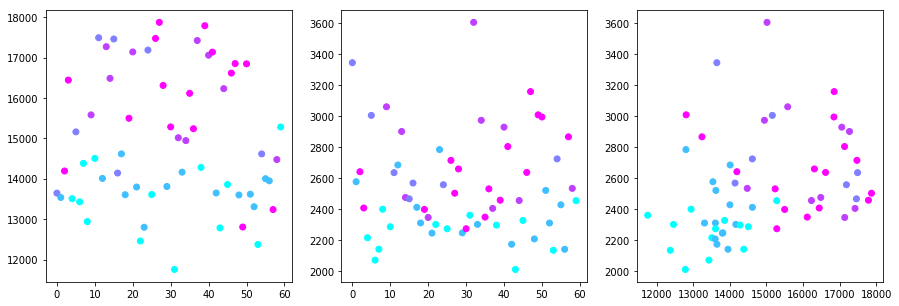

In [70]:
f,ax = plt.subplots(1,3,figsize=[15,5])
xarr = np.arange(What.shape[0])
ax[0].scatter(xarr,What[:,0],c=trial_info['morphs'][~trialmask],cmap='cool')
ax[1].scatter(xarr,What[:,1],c=trial_info['morphs'][~trialmask],cmap='cool')
ax[2].scatter(What[:,0],What[:,1],c=trial_info['morphs'][~trialmask],cmap='cool')
# f.savefig('discreteeg.pdf',format='pdf')

In [71]:

results = nmf.fit_ensemble(S_flatmat,np.arange(1,10),n_replicates=5)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:21<00:00, 14.21s/it]


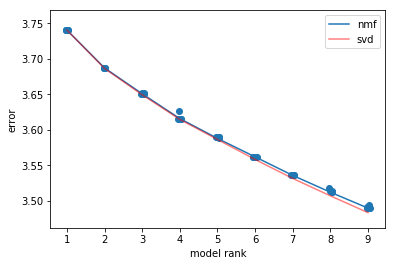

In [72]:
import plots 
plots.plot_rmse(results)

In [48]:
print(results.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])


In [78]:
W,H = results[3]['factors'][0][0], results[3]['factors'][0][1]

In [79]:
print(W.shape,H.shape)
print(S_flatmat.shape)

(120, 3) (3, 67770)
(120, 67770)


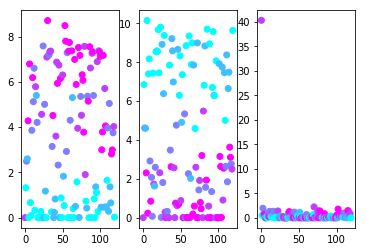

In [80]:
f,ax = plt.subplots(1,3)
xarr = np.arange(W.shape[0])
ax[0].scatter(xarr,W[:,0],c=trial_info['morphs'],cmap='cool')
ax[1].scatter(xarr,W[:,1],c=trial_info['morphs'],cmap='cool')
ax[2].scatter(xarr,W[:,2],c=trial_info['morphs'],cmap='cool')

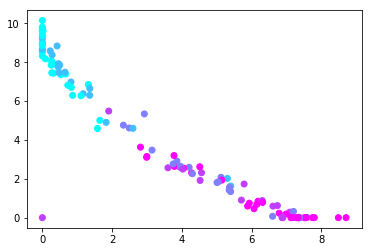

In [81]:
f,ax = plt.subplots()
ax.scatter(W[:,0],W[:,1],c=trial_info['morphs'],cmap='cool')

In [53]:
H_cells = H.reshape([2,S_trial_mat.shape[1],S_trial_mat.shape[2]])

In [54]:
print(H_cells.shape,S_trial_mat.shape)

(2, 45, 1951) (85, 45, 1951)


In [55]:
getSort = lambda fr : np.argsort(np.argmax(fr,axis=0),axis=0)


In [56]:
sort0,sort1 = getSort(H_cells[0,:,:]), getSort(H_cells[1,:,:])

In [57]:
print(sort0.shape)

(1951,)


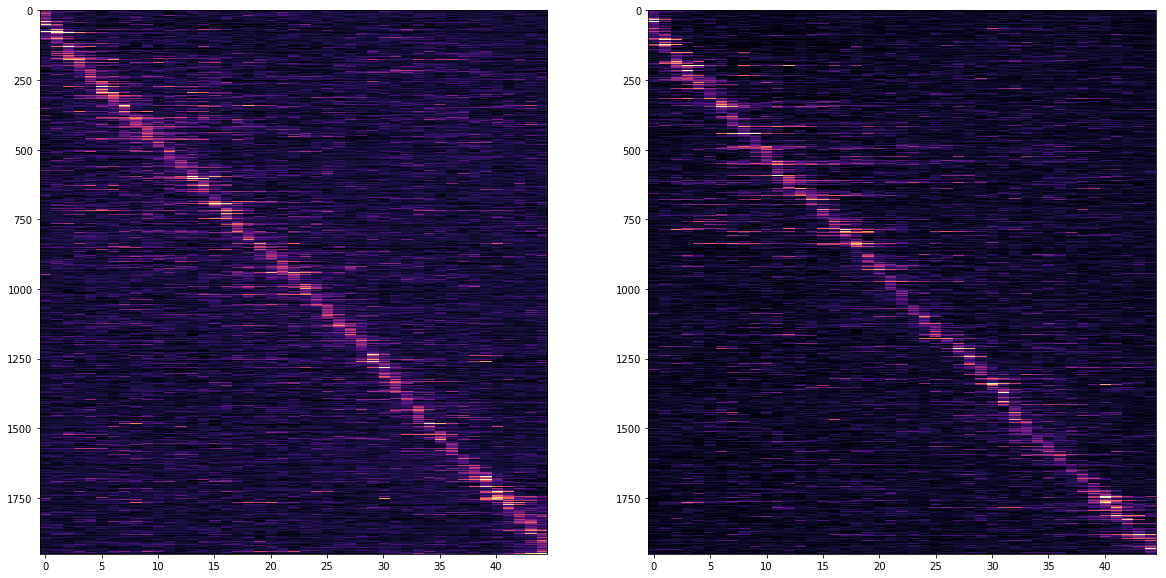

In [58]:
f,ax= plt.subplots(1,2,figsize=[20,10])
ax[0].imshow(H_cells[0,:,sort0],cmap='magma',aspect='auto',vmax=1)
ax[1].imshow(H_cells[1,:,sort1],cmap='magma',aspect='auto',vmax=1)

In [95]:
print(np.amin(H_cells),np.amax(H_cells))

0.0 4.9424092420746035


In [91]:
effMorph = trial_info['morphs']+ trial_info['bckgndJitter']+trial_info['wallJitter']
effMorph = (effMorph-np.amin(effMorph))/(np.amax(effMorph)-np.amin(effMorph)+.01)+.001

In [92]:
morph_edges = np.linspace(0,1,num=11)

In [95]:
m_dig=np.digitize(effMorph,morph_edges[1:])

In [96]:
print(m_dig)

[7 0 5 3 9 1 9 0 0 4 9 4 4 0 7 2 5 0 1 1 0 1 6 0 5 2 5 3 0 7 8 7 4 7 6 0 5
 9 3 3 2 7 6 8 5 6 2 9 0 1 7 3 0 9 9 4 5 0 9 8 4 0 9 3 0 0 9 3 8 1 7 9 3 9
 4 7 9 8 9 7 7 0 3 4 8 0 9 7 0 6 8 4 1 1 3 0 6 1 5 8 8 3 9 8 9 2 7 9 2 0 5
 3 5 3 2 9 8 4 6 0]


In [100]:
print([10].extend(list(S_trial_mat.shape[1:])))

None


In [110]:
a=list(S_trial_mat.shape)
a=a.extend([10])

In [111]:
print(a)

[120, 45, 1506, 10]


In [112]:
rm = u.morph_pos_rate_map(S_trial_mat,effMorph)

In [113]:
print(rm.shape)

(10, 45, 1506)
